# Antes de empezar

**Si no estas trabajando en un entorno de trabajo, crearlo:**  

\$ conda create -n chipExercise python=3.6.2 anaconda  
\$ source activate chipExercise  
\$ conda config --add channels conda-forge

**Instalar todas las librerias necesarias**  

\$ conda install jupyter  
\$ conda install jupyterlab  
\$ conda install matplotlib  
\$ conda install cycler  
\$ jupyter-lab ejercicio.ipynb 

In [1]:
%load_ext autoreload
%autoreload 2

# Importo dataset

In [2]:
import numpy as np
X_train = np.load('X_train.npy')
X_test = np.load('X_test.npy')
y_train = np.load('y_train.npy') 
y_test = np.load('y_test.npy')
print(X_train.shape)
print(X_test.shape)

(59, 2)
(59, 2)


# No olvidar instalar Keras:
\$ conda install keras

In [3]:
from keras.models import Sequential
from keras import optimizers
from keras.layers.core import Dense, Activation
from helper import PlotLosses
from keras.callbacks import ModelCheckpoint
from keras.initializers import RandomNormal

/Users/julianganzabal/anaconda3/envs/chipExercise/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# Parametros del modelo

In [4]:
# Paramtros fijos
input_shape = 2 # Tenemos solo 2 features
output_size = 1 # Solo tenemos 2 clases

# Parametros a modificar
hidden_units = 20 # Tratar de encontrar un tamaño optimo para el test set

# Probar distintos initializers
# kernel_initializer = 'zeros'
kernel_initializer = RandomNormal(mean=0.0, stddev=0.1, seed=None)

# Armo red neuronal
Cada vez que se cambia un parametro, ejecutar desde aca

In [5]:
model = Sequential()
model.add(Dense(hidden_units,input_dim=input_shape))
model.add(Activation('sigmoid'))
model.add(Dense(output_size, kernel_initializer=kernel_initializer))
model.add(Activation('sigmoid'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 20)                60        
_________________________________________________________________
activation_1 (Activation)    (None, 20)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 21        
_________________________________________________________________
activation_2 (Activation)    (None, 1)                 0         
Total params: 81
Trainable params: 81
Non-trainable params: 0
_________________________________________________________________


# Compilo y Entreno el modelo

In [6]:
# Para SGD lr=2 funciona ok pero muy lento: 40.000 epochs acc 1 (decay = 0) (20 hidden units)
# Para adam 0.4, decay = 0.002 converge enseguida (20 hidden units)
# Correrlo mas de una vez con los mismos parametros y verificar los resultados
lr = 0.4 # Modificarlo y ver que ocurre.
decay = 0.002 # Modificarlo y ver que ocurre
batch_size = 59 # 59 es el tamaño del train set. Seria hacer GD, en 1 seria SGD. Probar valores intermedios tambien
epochs = 2000

# Elejir uno de estos dos optimizadores. O buscar documentación y probar algun otro
# selectedOptimizer = optimizers.SGD(lr=lr, decay=decay)
selectedOptimizer = optimizers.adam(lr=lr, decay=decay)

# Lo compilo
model.compile(loss = 'binary_crossentropy', optimizer=selectedOptimizer, metrics=['accuracy'])

In [7]:
# Se puede tocar plot_interval para acelerar el proceso, el resto recomendamos no tocarlo
plot_losses = PlotLosses(plot_interval=100, 
                         evaluate_interval=None, 
                         x_val=X_test, 
                         y_val_categorical=y_test)

In [8]:
checkpointer = ModelCheckpoint(filepath='two_layer_model_best.hdf5', verbose=0, save_best_only=True)

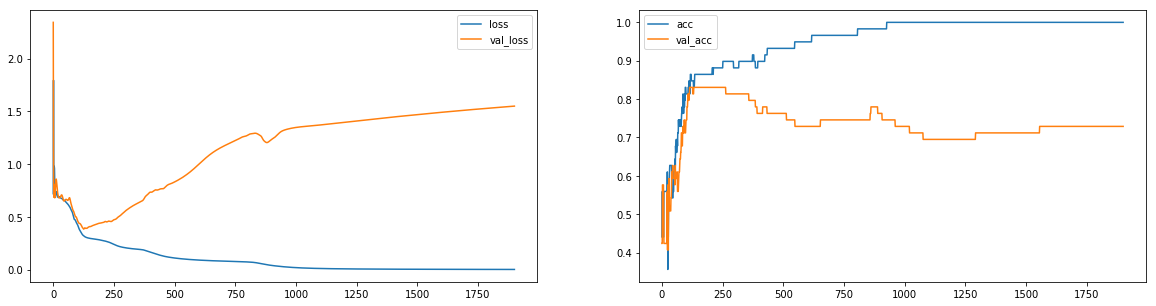

In [9]:
model.fit(X_train, 
          y_train, batch_size = batch_size,
          epochs=epochs, 
          verbose=0, 
          validation_data=(X_test, y_test), 
          callbacks=[plot_losses, checkpointer],
         )

In [10]:
model.save_weights('two_layer_model_last.hdf5')

# Grafico resultado al final del entrenamiento

59/59 [==============================] - 0s 46us/step


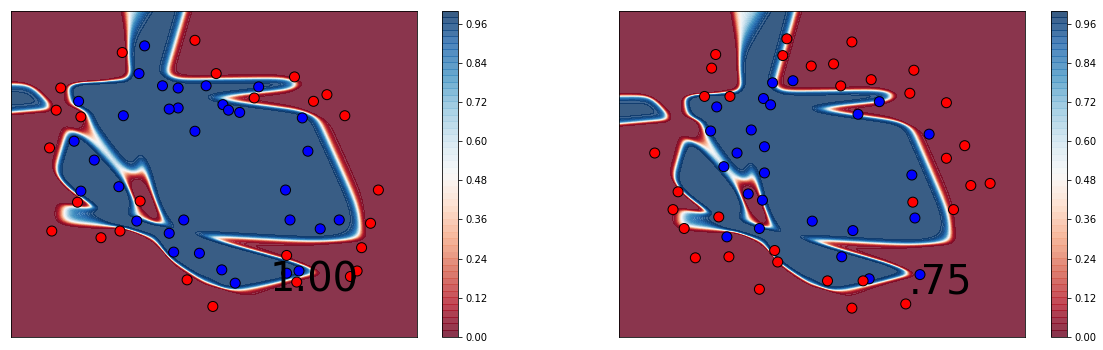

In [11]:
model.load_weights('two_layer_model_last.hdf5')
from helper import plot_boundaries
from matplotlib import pyplot as plt

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,6))
plot_boundaries(X_train, y_train, model.evaluate(X_train, y_train)[1], model.predict_proba, h = 0.005, margin=0.2, ax=ax1)
plot_boundaries(X_test, y_test, model.evaluate(X_test, y_test)[1], model.predict_proba, h = 0.005, margin=0.2, ax=ax2)
plt.show()

# Grafico mejor resultado guardado con el Checkpointer

59/59 [==============================] - 0s 41us/step


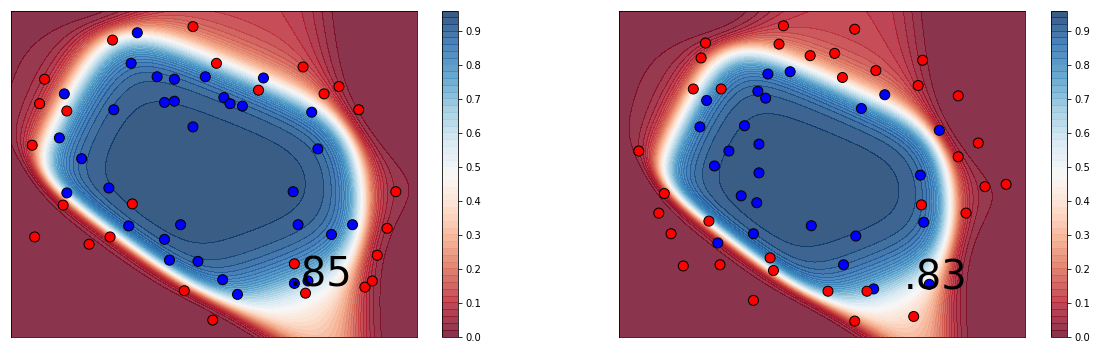

In [12]:
# Cargo pesos
model.load_weights('two_layer_model_best.hdf5')

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,6))
plot_boundaries(X_train, y_train, model.evaluate(X_train, y_train)[1], model.predict_proba, h = 0.005, margin=0.1, ax=ax1)
plot_boundaries(X_test, y_test, model.evaluate(X_test, y_test)[1], model.predict_proba, h = 0.005, margin=0.1, ax=ax2)
plt.show()

In [13]:
model.load_weights('two_layer_model_best.hdf5')
best_weights = model.get_weights()
model.load_weights('two_layer_model_last.hdf5')
last_weights = model.get_weights()

for i,layer_weights in enumerate(best_weights):
    print('mean:', layer_weights.mean(), layer_weights.shape, last_weights[i].mean())
    print('STD:', layer_weights.std(), layer_weights.shape, last_weights[i].std())
    print('MAX:', np.max(abs(layer_weights)), layer_weights.shape, np.max(abs(last_weights[i])))
    print()

mean: -2.9332623 (2, 20) -12.719403
STD: 7.32647 (2, 20) 29.642504
MAX: 14.879932 (2, 20) 76.257805

mean: -6.836764 (20,) -19.802395
STD: 2.2434695 (20,) 8.830393
MAX: 11.400751 (20,) 35.93723

mean: -1.5871396 (20, 1) -4.2524805
STD: 1.5899326 (20, 1) 9.669658
MAX: 6.412335 (20, 1) 15.110794

mean: 2.9986863 (1,) 7.164934
STD: 0.0 (1,) 0.0
MAX: 2.9986863 (1,) 7.164934

